## Cleaning data

In [116]:
import pandas as pd

data = pd.read_csv('combined_csv.csv')
data.head()

,Unnamed: 0,Topic Title,Category,Tags,Author,Commenters,Leading Comment,Other Comments,Likes,Views
0,0.0,About the Buying/Selling category,Buying/Selling,[],system,[],Debating a new ride? Ask all your buying and s...,[],1,2.2k
1,1.0,New Car Salesperson Commissions,Buying/Selling,[],wolyrobb,"['wentwest', 'shadowfax', 'VOLVO-V70', 'Trieda...",I’ve been working with a particular salesperso...,['No one here can tell you what any dealers co...,12,559
2,2.0,Best used car to buy for long road trips?,Buying/Selling,['used-cars'],Whitey,"['texases', 'VOLVO-V70', 'Marnet', 'lion9car',...",Hello! I am new to the site and am having a di...,['The answer to your question depends far more...,44,14.6k
3,3.0,Honda Element any good?,Buying/Selling,"['honda', 'element']",texases,"['VOLVO-V70', 'old_mopar_guy', 'lockstar', 'sh...",Are these any good and were they discontinued?...,['A simple Google search would have shown that...,24,1.2k
4,4.0,1993 4Runner vs 2011 Mazda3 Hatch,Buying/Selling,"['toyota', '4runner', 'buying', 'used-cars']",galant,"['wolyrobb', 'Nevada_545', 'jordanethan609_175...",I’m conflicted between these two cars\n4Runner...,['You are comparing apples to hamsters with th...,46,1.7k


## Data Exploration & Visualisation

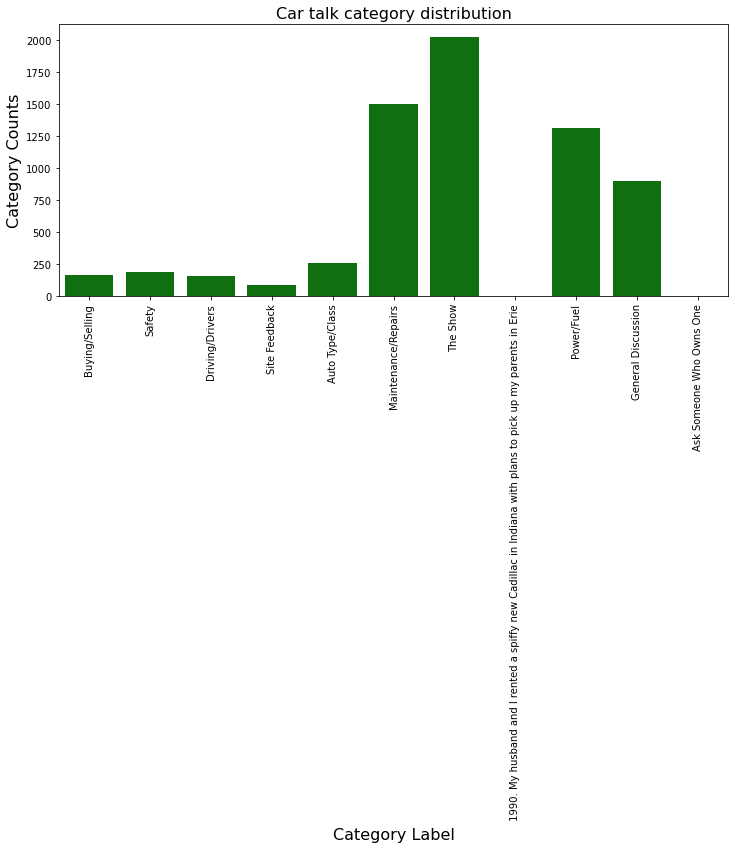

In [117]:
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
sns.countplot(x=amazon_text_df.Category, color='green')
plt.title('Car talk category distribution', fontsize=16)
plt.ylabel('Category Counts', fontsize=16)
plt.xlabel('Category Label', fontsize=16)
plt.xticks(rotation='vertical');

In [118]:
data.drop(columns= ['Unnamed: 0','Commenters'], inplace=True)

In [119]:
data = data[data.Category != ' 1990. My husband and I rented a spiffy new Cadillac in Indiana with plans to pick up my parents in Erie']

In [120]:
df = data.copy()

In [121]:
df['text'] = df['Tags'] + ' ' + df['Topic Title'] + ' ' + df['Leading Comment'] + ' ' + df['Other Comments']

In [122]:
from gensim import utils
import gensim.parsing.preprocessing as gsp

filters = [
           gsp.strip_tags, 
           gsp.strip_punctuation,
           gsp.strip_multiple_whitespaces,
           gsp.strip_numeric,
           gsp.remove_stopwords, 
           gsp.strip_short, 
           gsp.stem_text
          ]

def clean_text(s):
    s = s.lower()
    s = utils.to_unicode(s)
    for f in filters:
        s = f(s)
    return s

In [123]:
df.iloc[2,1]

'Buying/Selling'

In [124]:
clean_text(df.iloc[2,1])

'bui sell'

In [125]:
%matplotlib inline

from wordcloud import WordCloud

def plot_word_cloud(text):
    wordcloud_instance = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords=None,
                min_font_size = 10).generate(text) 
             
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud_instance) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show()

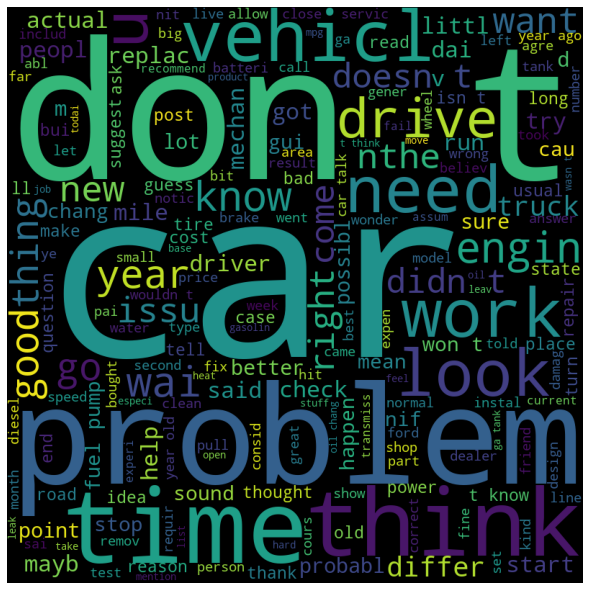

In [126]:
texts = ''
for index, item in df.iterrows():
    texts = texts + ' ' + clean_text(str(item['text']))
    
plot_word_cloud(texts)

In [127]:
df.rename(columns={"Category": "category"}, inplace=True)

In [128]:
def plot_word_cloud_for_category(df, category):
    text_df = df.loc[df['category'] == str(category)]
    texts = ''
    for index, item in text_df.iterrows():
        texts = texts + ' ' + clean_text(item['text'])
    
    plot_word_cloud(texts)

In [129]:
df.category.unique()

array(['Buying/Selling', 'Safety', 'Driving/Drivers', 'Site Feedback',
       'Auto Type/Class', 'Maintenance/Repairs', 'The Show', 'Power/Fuel',
       'General Discussion', 'Ask Someone Who Owns One'], dtype=object)

In [130]:
df.loc[df.category == 'Buying/Selling', 'Category'] = "Buying/Selling & Ask Someone Who Owns One"
df.loc[df.category == 'Ask Someone Who Owns One', 'Category'] = "Buying/Selling & Ask Someone Who Owns One"

In [131]:
df["text"].head()

0    [] About the Buying/Selling category Debating ...
1    [] New Car Salesperson Commissions I’ve been w...
2    ['used-cars'] Best used car to buy for long ro...
3    ['honda', 'element'] Honda Element any good? A...
4    ['toyota', '4runner', 'buying', 'used-cars'] 1...
Name: text, dtype: object

In [132]:
df["text"].isnull().sum()

7

In [133]:
df_x = df['text']
df_y = df['category']

In [134]:
df = df[df['post'].notna()]

KeyError: 'post'

## Building the Machine Learning model & pipeline
Converting to Doc2Vec

In [ ]:
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from sklearn.base import BaseEstimator
from sklearn import utils as skl_utils
from tqdm import tqdm

import multiprocessing
import numpy as np

class Doc2VecTransformer(BaseEstimator):

    def __init__(self, vector_size=100, learning_rate=0.02, epochs=20):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self._model = None
        self.vector_size = vector_size
        self.workers = multiprocessing.cpu_count() - 1

    def fit(self, df_x, df_y=None):
        tagged_x = [TaggedDocument(clean_text(row).split(), [index]) for index, row in enumerate(df_x)]
        model = Doc2Vec(documents=tagged_x, vector_size=self.vector_size, workers=self.workers)

        for epoch in range(self.epochs):
            model.train(skl_utils.shuffle([x for x in tqdm(tagged_x)]), total_examples=len(tagged_x), epochs=1)
            model.alpha -= self.learning_rate
            model.min_alpha = model.alpha

        self._model = model
        return self

    def transform(self, df_x):
        return np.asmatrix(np.array([self._model.infer_vector(clean_text(row).split())
                                     for index, row in enumerate(df_x)]))

In [ ]:
doc2vec_trf = Doc2VecTransformer()
doc2vec_features = doc2vec_trf.fit(df_x).transform(df_x)
doc2vec_features

Pipeline with Doc2Vec & LogisticRegression

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

pl_log_reg = Pipeline(steps=[('doc2vec',Doc2VecTransformer()),
                             ('log_reg', LogisticRegression(multi_class='multinomial', solver='saga', max_iter=100))])
scores = cross_val_score(pl_log_reg, df_x, df_y, cv=5,scoring='accuracy')
print('Accuracy for Logistic Regression: ', scores.mean())

Pipeline with Doc2Vec & RandomForest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

pl_random_forest = Pipeline(steps=[('doc2vec',Doc2VecTransformer()),
                                   ('random_forest', RandomForestClassifier())])
scores = cross_val_score(pl_random_forest, df_x, df_y, cv=5,scoring='accuracy')
print('Accuracy for RandomForest : ', scores.mean())

Pipeline with Doc2Vec & XGBoost

In [ ]:
import xgboost as xgb

pl_xgb = Pipeline(steps=[('doc2vec',Doc2VecTransformer()),
                         ('xgboost', xgb.XGBClassifier(objective='multi:softmax'))])
scores = cross_val_score(pl_xgb, df_x, df_y, cv=5)
print('Accuracy for XGBoost Classifier : ', scores.mean())

In [ ]:
Converting to Tf-Idf

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

class Text2TfIdfTransformer(BaseEstimator):

    def __init__(self):
        self._model = TfidfVectorizer()
        pass

    def fit(self, df_x, df_y=None):
        df_x = df_x.apply(lambda x : clean_text(x))
        self._model.fit(df_x)
        return self

    def transform(self, df_x):
        return self._model.transform(df_x)

In [ ]:
tfidf_transformer = Text2TfIdfTransformer()
tfidf_vectors = tfidf_transformer.fit(df_x).transform(df_x)

In [ ]:
tfidf_vectors.shape

In [ ]:
print(tfidf_vectors)

Pipeline with Tf-Idf & LogisticRegression

In [ ]:
pl_log_reg_tf_idf = Pipeline(steps=[('tfidf',Text2TfIdfTransformer()),
                                    ('log_reg', LogisticRegression(multi_class='multinomial', solver='saga', max_iter=100))])
scores = cross_val_score(pl_log_reg_tf_idf, df_x, df_y, cv=5,scoring='accuracy')
print('Accuracy for Tf-Idf & Logistic Regression: ', scores.mean())

Pipeline with Tf-Idf & RandomForest

In [ ]:
pl_random_forest_tf_idf = Pipeline(steps=[('tfidf',Text2TfIdfTransformer()),
                                          ('random_forest', RandomForestClassifier())])
scores = cross_val_score(pl_random_forest_tf_idf, df_x, df_y, cv=5,scoring='accuracy')
print('Accuracy for Tf-Idf & RandomForest : ', scores.mean())

Pipeline with Tf-Idf & XGBoost

In [ ]:
pl_xgb_tf_idf = Pipeline(steps=[('tfidf',Text2TfIdfTransformer()),
                         ('xgboost', xgb.XGBClassifier(objective='multi:softmax'))])
scores = cross_val_score(pl_xgb_tf_idf, df_x, df_y, cv=5)
print('Accuracy for Tf-Idf & XGBoost Classifier : ', scores.mean())
In [ ]:
